In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"
os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin"

import keras
import torch
torch.cuda.empty_cache()

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

2024-04-26 17:41:11.609917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 17:41:11.609989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 17:41:11.611442: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from keras.utils import image_dataset_from_directory
import pathlib

dir = pathlib.Path("/kaggle/input/waste-classification-data/DATASET")

train_dataset, validation_dataset = image_dataset_from_directory(
    dir / "TRAIN",
    labels="inferred",
    label_mode="binary",
    image_size=(223, 223),
    batch_size=32,
    validation_split=0.4,
    subset="both",
    seed=1729,
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    dir / "TEST",
    image_size=(223, 223),
    batch_size=32
)

for data_batch, label_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("label batch shape:", label_batch)
    break

Found 22564 files belonging to 2 classes.
Using 13539 files for training.
Using 9025 files for validation.
Found 2513 files belonging to 2 classes.
data batch shape: (32, 223, 223, 3)
label batch shape: tf.Tensor(
[[1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]], shape=(32, 1), dtype=float32)


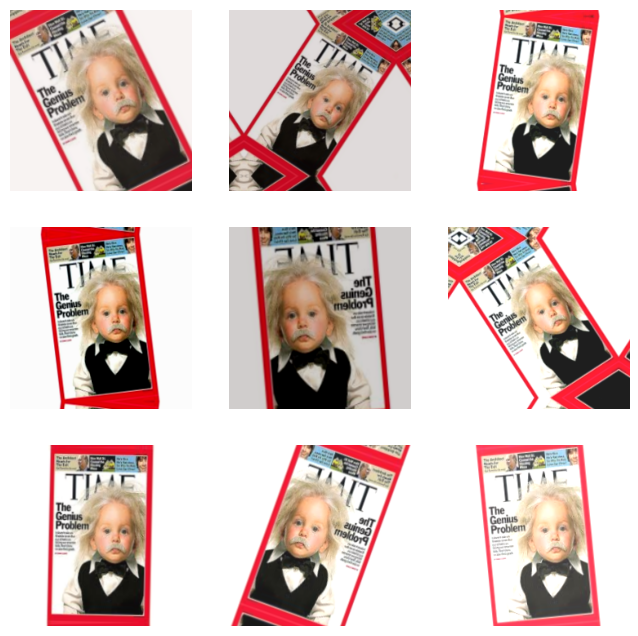

In [3]:
from keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].cpu().numpy().astype("uint8"))
        plt.axis("off")

In [4]:
def make_model_augmentation():
    inputs = keras.Input(shape=(223, 223, 3))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

def make_model():
    inputs = keras.Input(shape=(223, 223, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

def draw_history():
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epoches = range(1, len(accuracy) + 1)
    plt.plot(epoches, accuracy, "bo", label="Training Accuracy")
    plt.plot(epoches, val_accuracy, "b", label="Validation Accuracy")
    # plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epoches, loss, "bo", label="Training Loss")
    plt.plot(epoches, val_loss, "b", label="Validation Loss")
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## Model wtih Data Augmentation

In [5]:
model = make_model_augmentation()

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 223, 223, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 223, 223, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 223, 223, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 221, 221, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,004,097 (3.83 MB)

 Trainable params: 1,004,097 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convt_model_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/50


In [ ]:
draw_history()

test_model = keras.models.load_model("convt_model_augmentation.keras")
test_loss, test_accuracy = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.3f}")

## Model without Data Augmentation

In [ ]:
model = make_model()

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convt_model_no_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks
)

In [ ]:
draw_history()

test_model = keras.models.load_model("convt_model_no_augmentation.keras")
test_loss, test_accuracy = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.3f}")

# Transfer Learning

## Xception

In [ ]:
conv_base = keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(223, 223, 3)
)
conv_base.trainable = True
for layer in conv_base.layers[:-6]:
    layer.trainable = False

# conv_base.summary(show_trainable=True)

In [ ]:
inputs = keras.Input(shape=(223, 223, 3))
x = data_augmentation(inputs)
x = keras.applications.xception.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_Xception = keras.Model(inputs=inputs, outputs=outputs)
model_Xception.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
model_Xception.summary()

# dot_img_file = './model_Xception.png'
# keras.utils.plot_model(model_Xception, to_file=dot_img_file, show_shapes=True)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_Xception.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model_Xception.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

In [ ]:
draw_history()

test_model = keras.models.load_model("fine_tuning_Xception.keras")
test_loss, test_accuracy = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.3f}")

## Inception V3

In [ ]:
conv_base = keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(223, 223, 3)
)
conv_base.trainable = True
for layer in conv_base.layers[:-17]:
    layer.trainable = False

# conv_base.summary(show_trainable=True)

In [ ]:
inputs = keras.Input(shape=(223, 223, 3))
x = data_augmentation(inputs)
x = keras.applications.inception_v3.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
model.summary()

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_InceptionV3.keras",
        save_best_only=True,
        monitor="val_loss",
        mode="min"
    )
]

history = model.fit(
    train_dataset,
    epochs=100
    validation_data=validation_dataset,
    callbacks=callbacks
)

In [ ]:
draw_history()

test_model = keras.models.load_model("fine_tuning_InceptionV3.keras")
test_loss, test_accuracy = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.3f}")